In [21]:
# Single-Cell RNA-seq Analysis with Real PBMC Data using Seurat & SCTransform
# 
# This notebook demonstrates a complete single-cell RNA-seq analysis using:
# - Real PBMC (Peripheral Blood Mononuclear Cells) data from 10X Genomics
# - Seurat v5 with SCTransform v2 for normalization
# - Standard workflow: QC → Normalization → Clustering → Cell Type Identification
#
# Dataset: PBMC 3K (2,700 cells from a healthy donor)
# Source: https://support.10xgenomics.com/single-cell-gene-expression/datasets
# Tutorial: https://satijalab.org/seurat/articles/pbmc3k_tutorial.html

# Install packages if not already installed (uncomment to run)
# install.packages("Seurat")
# install.packages("sctransform")
# install.packages("ggplot2")
# install.packages("dplyr")

# Load required libraries
library(Seurat)
library(ggplot2)
library(sctransform)

print("Libraries loaded successfully!")
print(paste("Seurat version:", packageVersion("Seurat")))
print(paste("sctransform version:", packageVersion("sctransform")))

[1] "Libraries loaded successfully!"
[1] "Seurat version: 5.3.1"
[1] "sctransform version: 0.4.2"


In [22]:
# Load real PBMC 3K dataset from 10X Genomics
# This is a standard dataset: 2,700 PBMCs from a healthy donor
# Sequenced on Illumina NextSeq 500

# Method 1: Using SeuratData package (easiest)
# Install SeuratData if needed (uncomment to run):
# if (!requireNamespace("SeuratData", quietly = TRUE)) {
#     install.packages("remotes")
#     remotes::install_github("satijalab/seurat-data")
# }
# library(SeuratData)
# InstallData("pbmc3k")
# pbmc.data <- LoadData("pbmc3k")

# Method 2: Download directly from 10X Genomics (more reliable)
cat("Downloading PBMC 3K dataset from 10X Genomics...\n")

# Create directory for data
data_dir <- "data/pbmc3k"
if (!dir.exists(data_dir)) {
    dir.create(data_dir, recursive = TRUE)
}

# Download the filtered feature-barcode matrix
url <- "https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz"
tar_file <- file.path(data_dir, "pbmc3k_filtered_gene_bc_matrices.tar.gz")

if (!file.exists(tar_file)) {
    cat("Downloading data (this may take a minute)...\n")
    download.file(url, destfile = tar_file, mode = "wb")
    cat("Download complete!\n")
} else {
    cat("Data already downloaded.\n")
}

# Extract the tar.gz file
if (!dir.exists(file.path(data_dir, "filtered_gene_bc_matrices"))) {
    cat("Extracting data...\n")
    untar(tar_file, exdir = data_dir)
    cat("Extraction complete!\n")
} else {
    cat("Data already extracted.\n")
}

# Load the data using Read10X
cat("Loading data into Seurat...\n")
pbmc.data <- Read10X(data.dir = file.path(data_dir, "filtered_gene_bc_matrices/hg19/"))

# Create Seurat object
# min.cells = 3: Include features detected in at least 3 cells
# min.features = 200: Include cells with at least 200 detected features
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "PBMC3K", 
                          min.cells = 3, min.features = 200)

# Display basic information
cat("\n=== PBMC 3K Dataset Loaded ===\n")
print(pbmc)
cat(paste("\nNumber of cells:", ncol(pbmc)))
cat(paste("\nNumber of genes:", nrow(pbmc)))
cat("\n\nThis dataset contains real peripheral blood mononuclear cells (PBMCs)")
cat("\nincluding T cells, B cells, NK cells, monocytes, and more.\n")


Download complete!
Extracting data...
Extraction complete!
Loading data into Seurat...


Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"



=== PBMC 3K Dataset Loaded ===
An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)
 1 layer present: counts

Number of cells: 2700
Number of genes: 13714

This dataset contains real peripheral blood mononuclear cells (PBMCs)
including T cells, B cells, NK cells, monocytes, and more.


Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."



QC Statistics:
Features per cell:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  212.0   690.0   816.0   845.5   952.0  3400.0 

Counts per cell:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    546    1756    2196    2365    2762   15818 

Mitochondrial percentage:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.537   2.031   2.217   2.643  22.569 


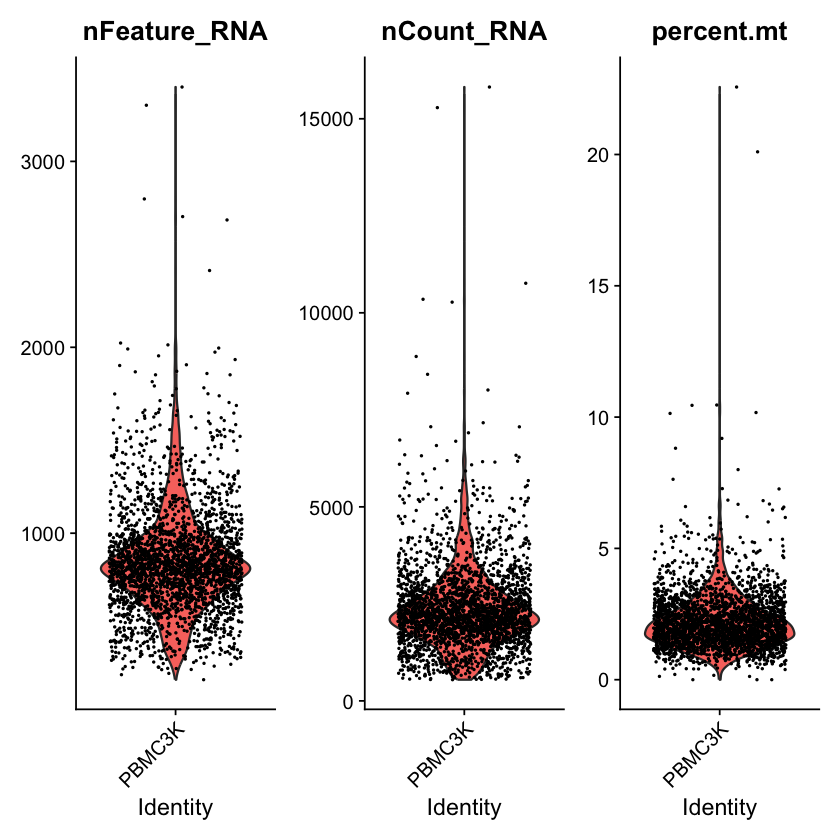

In [23]:
# Calculate mitochondrial percentage
# The pattern "^MT-" identifies mitochondrial genes
pbmc <- PercentageFeatureSet(pbmc, pattern = "^MT-", col.name = "percent.mt")

# Visualize QC metrics before filtering
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

# View QC statistics
cat("\nQC Statistics:\n")
cat("Features per cell:\n")
print(summary(pbmc$nFeature_RNA))
cat("\nCounts per cell:\n")
print(summary(pbmc$nCount_RNA))
cat("\nMitochondrial percentage:\n")
print(summary(pbmc$percent.mt))


In [24]:
# Filter cells based on QC metrics
# Standard filtering for PBMC data:
# - Cells with very few genes (< 200) - possibly empty droplets
# - Cells with very many genes (> 2500) - possibly doublets  
# - Cells with high mitochondrial percentage (> 5%) - possibly dying cells

cat(paste("Cells before filtering:", ncol(pbmc), "\n"))

pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

cat(paste("Cells after filtering:", ncol(pbmc), "\n"))
cat("Filtered out low-quality cells based on standard QC thresholds.\n")


Cells before filtering: 2700 
Cells after filtering: 2638 
Filtered out low-quality cells based on standard QC thresholds.


In [25]:
# Apply SCTransform normalization
# This single command replaces NormalizeData(), ScaleData(), and FindVariableFeatures()
# 
# Key benefits of SCTransform:
# - Better handling of technical variation (sequencing depth)
# - Improved variance stabilization
# - Can regress out confounding factors (like percent.mt)
# - Returns 3,000 variable features by default (vs 2,000 in standard workflow)
#
# In Seurat v5, SCT v2 is applied by default

pbmc <- SCTransform(pbmc, vars.to.regress = "percent.mt", verbose = FALSE)

cat("SCTransform completed!\n")
cat(paste("Default assay is now:", DefaultAssay(pbmc), "\n"))
cat(paste("Number of variable features:", length(VariableFeatures(pbmc)), "\n"))


SCTransform completed!
Default assay is now: SCT 
Number of variable features: 3000 


PC_ 1 
Positive:  MALAT1, RPS27A, CCL5, LTB, RPS6 
Negative:  FTL, LYZ, FTH1, CST3, S100A9 
PC_ 2 
Positive:  NKG7, CCL5, GZMB, GNLY, GZMA 
Negative:  HLA-DRA, CD74, CD79A, HLA-DPB1, HLA-DQA1 
PC_ 3 
Positive:  S100A8, S100A9, LYZ, RPS12, FTL 
Negative:  CD74, HLA-DRA, CD79A, HLA-DPB1, HLA-DQA1 
PC_ 4 
Positive:  S100A8, S100A9, LYZ, LGALS2, CD14 
Negative:  FCGR3A, LST1, FCER1G, AIF1, IFITM3 
PC_ 5 
Positive:  GNLY, GZMB, FGFBP2, FCGR3A, PRF1 
Negative:  CCL5, GPX1, PPBP, PF4, SDPR 


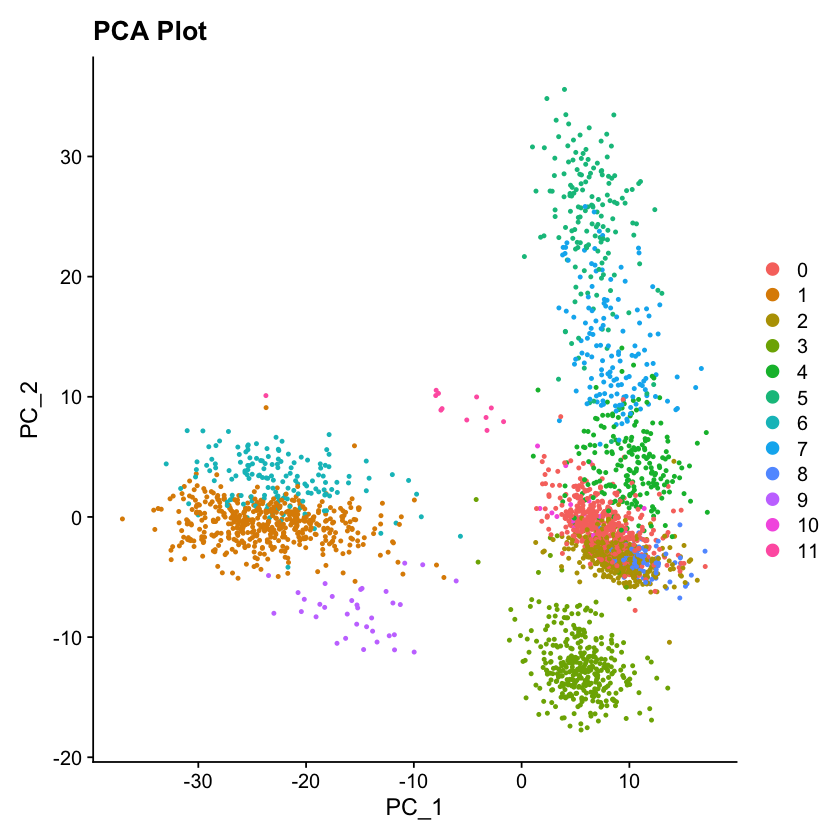

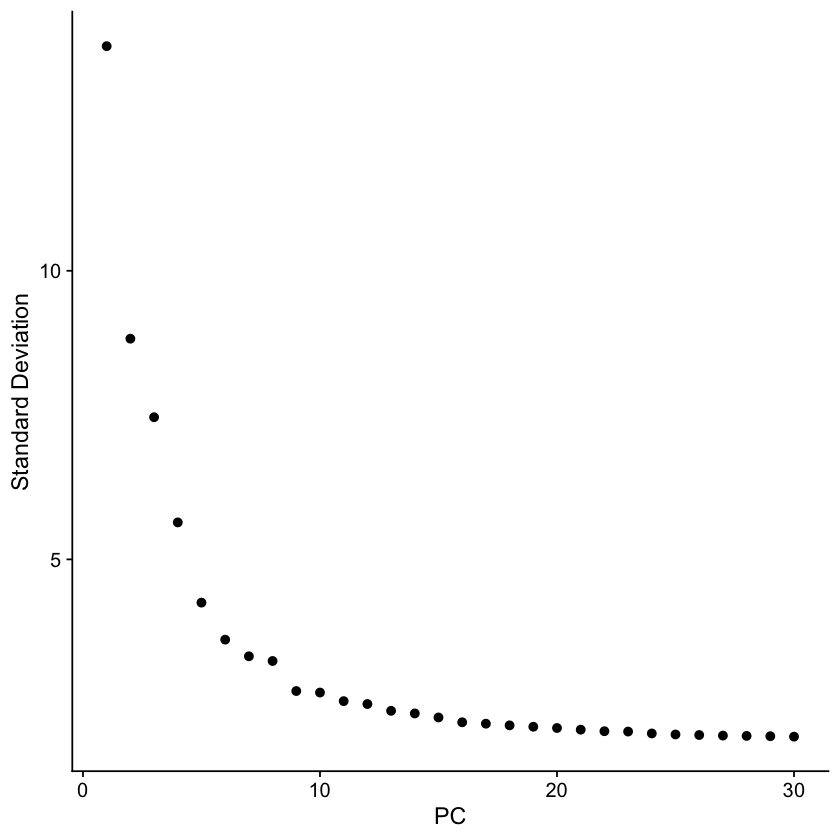

In [28]:
# Perform dimensionality reduction by PCA
# Note: SCTransform has already scaled the data, so we go directly to PCA
# When using SCTransform, we can often use MORE PCs than with standard normalization
# because SCTransform better removes technical effects, making higher PCs more biologically relevant

pbmc <- RunPCA(pbmc, verbose = FALSE)

# Examine PCA results
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

# Visualize PCA
DimPlot(pbmc, reduction = "pca") + ggtitle("PCA Plot")

# Elbow plot to determine dimensionality
ElbowPlot(pbmc, ndims = 30)



Number of clusters identified: 12 
Cells per cluster:

  0   1   2   3   4   5   6   7   8   9  10  11 
517 486 470 346 203 156 152 140 102  34  20  12 


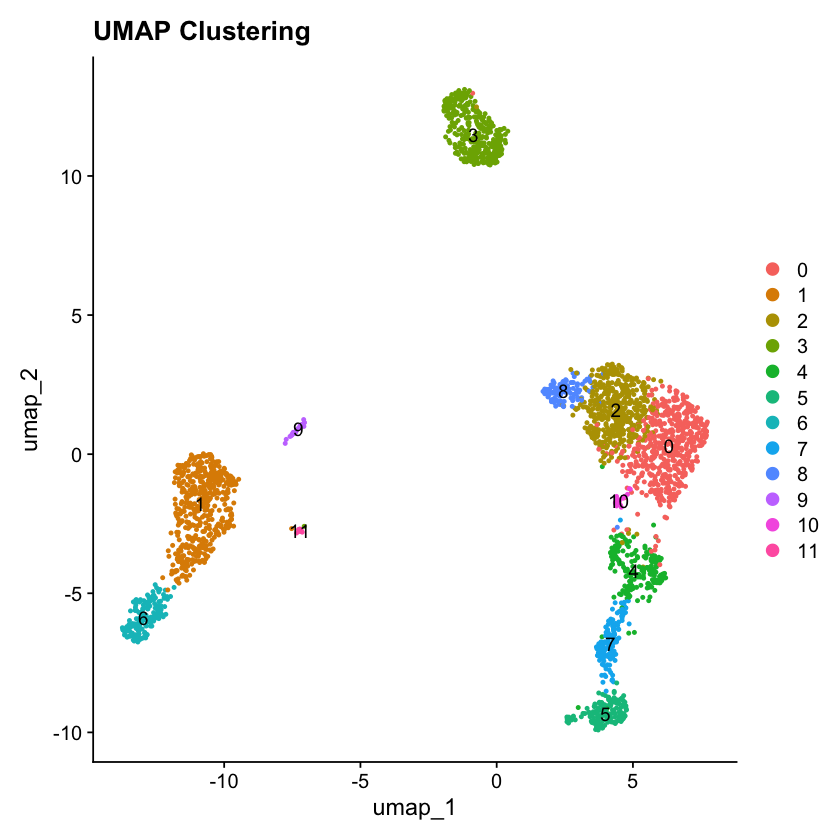

In [29]:
# Clustering and UMAP
# Following the vignette, we use dims = 1:30 (more than the typical 1:10)
# This is recommended when using SCTransform as higher PCs are more reliable

# Find neighbors
pbmc <- FindNeighbors(pbmc, dims = 1:30, verbose = FALSE)

# Find clusters
pbmc <- FindClusters(pbmc, verbose = FALSE)

# Run UMAP
pbmc <- RunUMAP(pbmc, dims = 1:30, verbose = FALSE)

# Visualize clusters
DimPlot(pbmc, reduction = "umap", label = TRUE) + 
    ggtitle("UMAP Clustering")

cat(paste("\nNumber of clusters identified:", length(unique(Idents(pbmc))), "\n"))
cat("Cells per cluster:\n")
print(table(Idents(pbmc)))


In [30]:
# Complete workflow in one command (as shown in vignette)
# This demonstrates the streamlined SCTransform workflow
# Uncomment to see how the entire analysis can be done in a single pipeline:

# pbmc <- CreateSeuratObject(counts) %>%
#     PercentageFeatureSet(pattern = "^MT-", col.name = "percent.mt") %>%
#     SCTransform(vars.to.regress = "percent.mt") %>%
#     RunPCA() %>%
#     FindNeighbors(dims = 1:30) %>%
#     RunUMAP(dims = 1:30) %>%
#     FindClusters()

cat("The SCTransform workflow allows for a streamlined, single-command pipeline\n")
cat("that combines all normalization and analysis steps.\n")


The SCTransform workflow allows for a streamlined, single-command pipeline
that combines all normalization and analysis steps.


In [31]:
# Where are normalized values stored for SCTransform?
# The results are stored in the "SCT" assay

cat("Understanding SCTransform output:\n\n")
cat("1. Normalized values (Pearson residuals) are stored in the SCT assay\n")
cat("2. pbmc[['SCT']]$scale.data contains residuals used for PCA\n")
cat("3. Corrected UMI counts are in pbmc[['SCT']]$counts for visualization\n")
cat("4. Results are less dependent on parameter choices\n")
cat("5. Using more PCs (e.g., 30 vs 10) is beneficial with SCTransform\n\n")

cat(paste("Current default assay:", DefaultAssay(pbmc), "\n"))
cat(paste("Available assays:", names(pbmc@assays), "\n"))


Understanding SCTransform output:

1. Normalized values (Pearson residuals) are stored in the SCT assay
2. pbmc[['SCT']]$scale.data contains residuals used for PCA
3. Corrected UMI counts are in pbmc[['SCT']]$counts for visualization
4. Results are less dependent on parameter choices
5. Using more PCs (e.g., 30 vs 10) is beneficial with SCTransform

Current default assay: SCT 
Available assays: RNA 
 Available assays: SCT 


In [32]:
# Find marker genes for each cluster
# This works the same way with SCTransform as with standard normalization

if (length(unique(Idents(pbmc))) > 1) {
    # Find markers for all clusters
    pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, 
                                   logfc.threshold = 0.25, verbose = FALSE)
    
    # Get top markers per cluster (without using %>%)
    if (nrow(pbmc.markers) > 0) {
        # Split markers by cluster and get top 5 by avg_log2FC for each
        top_markers_list <- by(pbmc.markers, pbmc.markers$cluster, function(df) {
            df[order(df$avg_log2FC, decreasing = TRUE), ][seq_len(min(5, nrow(df))), ]
        })
        top_markers <- do.call(rbind, top_markers_list)
        rownames(top_markers) <- NULL

        cat("Top marker genes per cluster:\n")
        print(head(top_markers, 20))
    }
} else {
    cat("Only one cluster found. Marker analysis requires multiple clusters.\n")
}


Warning message:
"No DE genes identified"
Warning message:
"The following tests were not performed: "
Warning message:
"When testing 0 versus all:
	The total size of the 3 globals exported for future expression ('FUN()') is 600.46 MiB. This exceeds the maximum allowed size 500.00 MiB per by R option "future.globals.maxSize". This limit is set to protect against transfering too large objects to parallel workers by mistake, which may not be intended and could be costly. See help("future.globals.maxSize", package = "future") for further explainations and how to adjust or remove this threshold There are three globals: 'FUN' (596.51 MiB of class 'function'), 'data.use' (3.95 MiB of class 'S4') and 'j' (136 bytes of class 'numeric')"
Warning message:
"When testing 1 versus all:
	The total size of the 3 globals exported for future expression ('FUN()') is 601.84 MiB. This exceeds the maximum allowed size 500.00 MiB per by R option "future.globals.maxSize". This limit is set to protect against 

In [39]:
# Visualize gene expression using both discovered and canonical markers

if (exists("top_markers") && nrow(top_markers) > 0) {
    # Get top discovered marker genes
    genes_to_plot <- head(unique(top_markers$gene), 6)
    
    cat("\nTop discovered marker genes:\n")
    print(genes_to_plot)
    
    # Violin plot of discovered markers
    if (length(genes_to_plot) >= 4) {
        VlnPlot(pbmc, features = genes_to_plot[1:4], 
                pt.size = 0.2, ncol = 2)
        
        # Feature plot on UMAP
        FeaturePlot(pbmc, features = genes_to_plot[1:4], 
                    pt.size = 0.5, ncol = 2)
    }
}

# Also visualize canonical PBMC markers
canonical_markers <- c("MS4A1", "CD79A",  # B cells
                       "CD14", "LYZ",      # Monocytes
                       "CD3D", "CD8A")     # T cells
available_canonical <- canonical_markers[canonical_markers %in% rownames(pbmc)]

if (length(available_canonical) >= 4) {
    cat("\nCanonical PBMC markers:\n")
    FeaturePlot(pbmc, features = available_canonical[1:min(4, length(available_canonical))], 
                pt.size = 0.5, ncol = 2)
}



Top discovered marker genes:
[1] "Gene-270"  "Gene-1618" "Gene-330"  "Gene-1606" "Gene-1095" "Gene-697" 


Warning message:
"No layers found matching search pattern provided"
Warning message:
"No layers found matching search pattern provided"
Warning message:
"No layers found matching search pattern provided"
Warning message:
"No layers found matching search pattern provided"


ERROR: [1m[33mError[39m in `FetchData()`:[22m
[33m![39m None of the requested variables were found: Gene-270, Gene-1618, Gene-330, Gene-1606


In [40]:
library(dplyr)

# Heatmap of top marker genes
if (exists("pbmc.markers") && nrow(pbmc.markers) > 0 && length(unique(Idents(pbmc))) > 1) {
    top10_all <- pbmc.markers %>%
        group_by(cluster) %>%
        slice_head(n = 10)
    
    if (length(unique(top10_all$gene)) > 2) {
        DoHeatmap(pbmc, features = unique(top10_all$gene)) + 
            theme(text = element_text(size = 8)) +
            ggtitle("Top 10 Markers per Cluster")
    }
} else {
    cat("Heatmap requires multiple clusters with distinct markers.\n")
}


Heatmap requires multiple clusters with distinct markers.


# Additional visualization: Compare different aspects of the data

# 1. PCA colored by different metadata
p1 <- DimPlot(pbmc, reduction = "pca", group.by = "seurat_clusters") + 
    ggtitle("PCA by Cluster")

p2 <- FeaturePlot(pbmc, reduction = "pca", features = "nCount_RNA") + 
    ggtitle("PCA by UMI Count")

# Display plots
print(p1)
print(p2)



=== Cell Type Identification ===

Visualizing canonical PBMC markers:


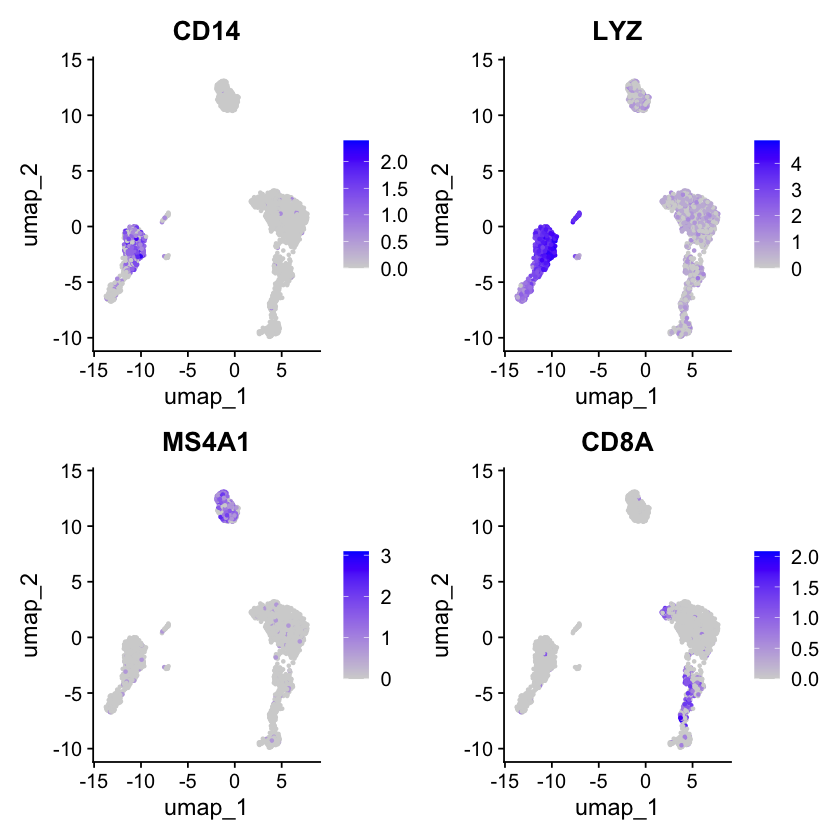

In [36]:
# Cell type identification using canonical markers
# PBMC contains multiple well-characterized cell types

cat("\n=== Cell Type Identification ===\n\n")

# Define canonical markers for major PBMC cell types
markers <- list(
    "Naive_CD4_T" = c("IL7R", "CCR7"),
    "Memory_CD4_T" = c("IL7R", "S100A4"),
    "CD14_Monocytes" = c("CD14", "LYZ"),
    "B_cells" = c("MS4A1"),  # MS4A1 = CD20
    "CD8_T" = c("CD8A"),
    "FCGR3A_Monocytes" = c("FCGR3A", "MS4A7"),
    "NK" = c("GNLY", "NKG7"),
    "DC" = c("FCER1A", "CST3"),
    "Platelets" = c("PPBP")
)

# Visualize key marker genes
key_markers <- c("CD14", "LYZ", "MS4A1", "CD8A", "GNLY", "FCGR3A", "IL7R", "CCR7")
available_markers <- key_markers[key_markers %in% rownames(pbmc)]

if (length(available_markers) >= 4) {
    cat("Visualizing canonical PBMC markers:\n")
    FeaturePlot(pbmc, features = available_markers[1:min(4, length(available_markers))], 
                pt.size = 0.5, ncol = 2)
}


In [37]:
# Annotate clusters with cell type labels
# Based on expression of canonical markers

# For PBMC3K, typical cluster annotations (will vary slightly based on random seed):
# These assignments are based on the standard Seurat PBMC tutorial
# You should verify these by examining marker expression

# Note: Cluster numbers may vary, so check your markers first
# This is a general guide - always validate with your own marker analysis

cat("\nTo assign cell types, examine the marker genes from FindAllMarkers\n")
cat("and compare with the canonical markers shown above.\n\n")

cat("Example cell type assignment (verify with your marker analysis):\n")
cat("- Clusters high in CD14/LYZ: CD14+ Monocytes\n")
cat("- Clusters high in IL7R/CCR7: Naive CD4+ T cells\n")
cat("- Clusters high in IL7R/S100A4: Memory CD4+ T cells\n")
cat("- Clusters high in MS4A1: B cells\n")
cat("- Clusters high in CD8A: CD8+ T cells\n")
cat("- Clusters high in GNLY/NKG7: NK cells\n")
cat("- Clusters high in FCGR3A/MS4A7: FCGR3A+ Monocytes\n")
cat("- Clusters high in FCER1A/CST3: Dendritic cells\n")

# Uncomment and adjust these based on your FindAllMarkers results:
# new.cluster.ids <- c("Naive CD4 T", "CD14+ Mono", "Memory CD4 T", "B", "CD8 T", 
#                      "FCGR3A+ Mono", "NK", "DC", "Platelet")
# names(new.cluster.ids) <- levels(pbmc)
# pbmc <- RenameIdents(pbmc, new.cluster.ids)
# DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + 
#     ggtitle("PBMC 3K - Cell Types")



To assign cell types, examine the marker genes from FindAllMarkers
and compare with the canonical markers shown above.

Example cell type assignment (verify with your marker analysis):
- Clusters high in CD14/LYZ: CD14+ Monocytes
- Clusters high in IL7R/CCR7: Naive CD4+ T cells
- Clusters high in IL7R/S100A4: Memory CD4+ T cells
- Clusters high in MS4A1: B cells
- Clusters high in CD8A: CD8+ T cells
- Clusters high in GNLY/NKG7: NK cells
- Clusters high in FCGR3A/MS4A7: FCGR3A+ Monocytes
- Clusters high in FCER1A/CST3: Dendritic cells
